In [1]:
import numpy as np
import pandas as pd
import warnings
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from IPython.core.display import HTML
from rdkit.Chem.QED import qed
from rdkit.Chem import PandasTools
def show(df):
    return HTML(df.to_html(notebook=True))
PandasTools.RenderImagesInAllDataFrames(images=True)
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
 
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
results=pd.read_pickle('new_generated_suzuki_with_maccs_sim_true_structure.pkl')

In [8]:
#results.to_csv('new_generated_suzuki_with_maccs_sim_true_structure.csv')

In [5]:
#results=pd.read_pickle('generated_suzuki_with_maccs_sim.pkl')
# X = torch.tensor(results['maccs'].tolist(), dtype=torch.float32)
# y = torch.tensor(results['max_maccs_sim'].tolist(), dtype=torch.float32)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=99)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# X_train = X_train.to(device)
# X_test = X_test.to(device)
# y_train = y_train.to(device)
# y_test = y_test.to(device)

results['maccs_1d'] = results['maccs'].apply(lambda x: [item for sublist in x for item in sublist])

# X = results['maccs'].tolist()

# y = results['max_maccs_sim'].tolist()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=99)

In [6]:
results.index = range(0, 90048)
results= results.set_index(results.index)
#results

In [7]:
X = results['maccs_1d'].to_list()

In [8]:
X=pd.DataFrame(X)

In [9]:
X.head(1)

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0


In [10]:
new_columns = {}
for i in range(len(X.columns)):
    new_columns[i] = 'feature{}'.format(i)

X.rename(columns=new_columns, inplace=True)

In [11]:
X.head(1)

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature324,feature325,feature326,feature327,feature328,feature329,feature330,feature331,feature332,feature333
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0


In [41]:
#X = results['maccs_1d']

y = results['max_maccs_sim']
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2,random_state=99)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5,random_state=99)
# X_train=np.array(X_train)
# X_test=np.array(X_test)
# y_train=np.array(y_train)
# y_test=np.array(y_test)


In [42]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(random_state=42,max_depth=10)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [44]:
from sklearn import metrics
y_valid_predict=xgb_model.predict(X_val)
xgb_valid=metrics.mean_squared_error(y_val,y_valid_predict)
print('xgb_valid:',xgb_valid)
y_predict=xgb_model.predict(X_test)
xgb_test=metrics.mean_squared_error(y_test,y_predict)
print('xgb_test:',xgb_test)


xgb_valid: 6.502740402944651e-05
xgb_test: 6.089662093373667e-05


In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso

rf=RandomForestRegressor(random_state=66)
ridge=Ridge(alpha=0.1,random_state=66)
lasso=Lasso(alpha=0.1,random_state=66)

rf.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1, random_state=66)

In [46]:
y_valid_predict_rf=rf.predict(X_val)
rf_valid=metrics.mean_squared_error(y_val,y_valid_predict_rf)
y_predict_rf=rf.predict(X_test)
rf_test=metrics.mean_squared_error(y_test,y_predict_rf)

y_valid_predict_ridge=ridge.predict(X_val)
ridge_valid=metrics.mean_squared_error(y_val,y_valid_predict_ridge)
y_predict_ridge=ridge.predict(X_test)
ridge_test=metrics.mean_squared_error(y_test,y_predict_ridge)

y_valid_predict_lasso=lasso.predict(X_val)
lasso_valid=metrics.mean_squared_error(y_val,y_valid_predict_lasso)
y_predict_lasso=lasso.predict(X_test)
lasso_test=metrics.mean_squared_error(y_test,y_predict_lasso)

In [48]:
print('rf_valid:',rf_valid)
print('rf_test',rf_test)

rf_valid: 7.183764205387193e-05
rf_test 7.211591767452794e-05


In [49]:
ridge_test

0.0004332142670576399

In [51]:
lasso_test

0.0019489109437568406

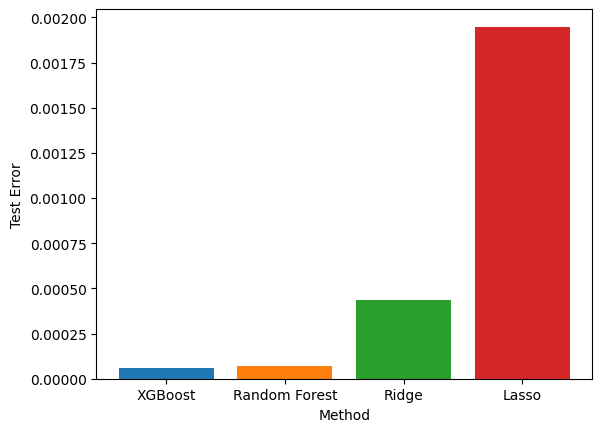

In [52]:
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
loss=[xgb_test,rf_test,ridge_test,lasso_test]
method=['XGBoost','Random Forest','Ridge','Lasso']
plt.bar(method, loss,color=colors)
plt.xlabel('Method')
plt.ylabel('Test Error')
plt.show()

In [53]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

[13:26:34] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


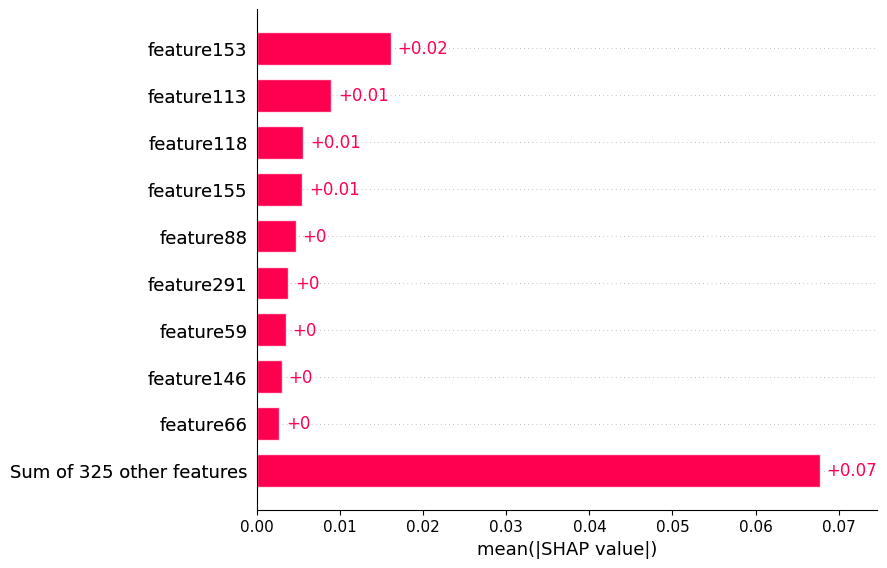

In [54]:
shap.plots.bar(shap_values, max_display=10)

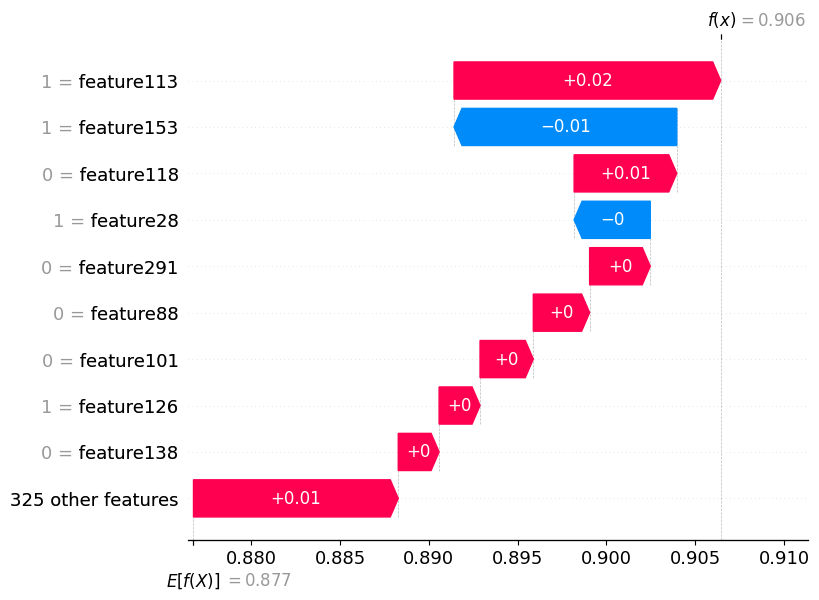

In [55]:
shap.plots.waterfall(shap_values[0]) # For the first observation

In [56]:
shap.initjs()

In [57]:

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)


[13:27:08] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


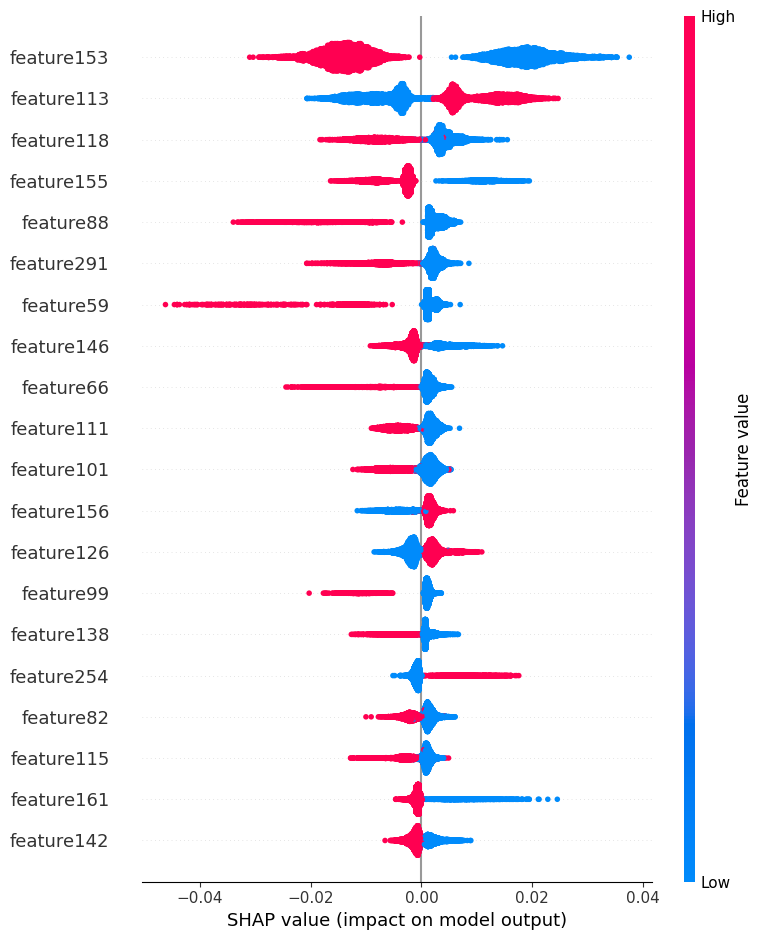

In [58]:
shap.summary_plot(shap_values, X_test)

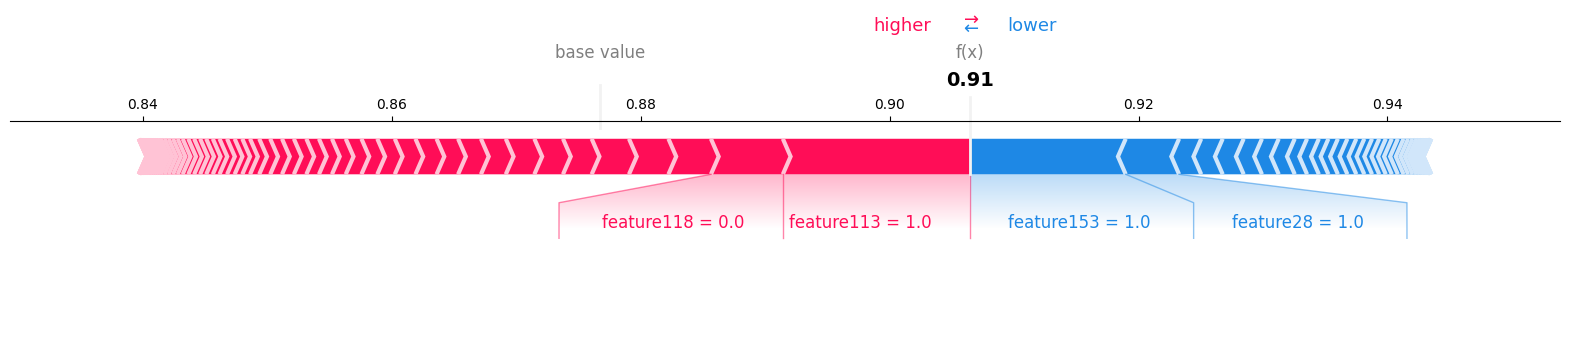

In [59]:
def p(j):
    return(shap.force_plot(explainer.expected_value, shap_values[j,:], X_test.iloc[j,:], matplotlib=True))
p(0)

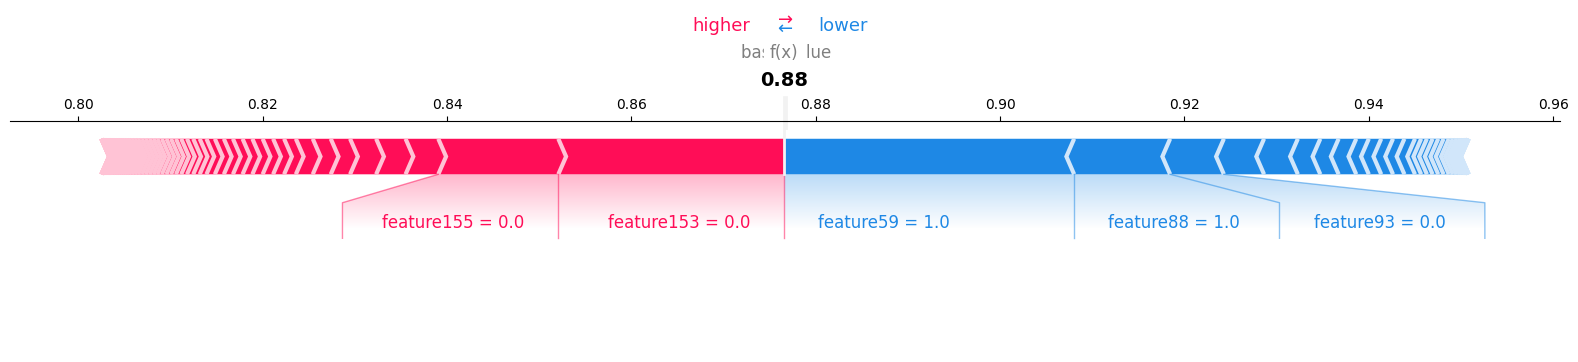

In [74]:
p(16)

In [75]:
X_test[16:17]

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature324,feature325,feature326,feature327,feature328,feature329,feature330,feature331,feature332,feature333
29013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,1,0


In [76]:
results[29013:29014]

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,Unnamed: 0,rxn_smiles,maccs,max_maccs_sim,maccs_1d
29013,29013,Cc1ccnc(Cl)c1.OB(O)c1cc(S)ccn1>>Cc1ccnc(-c2cc(...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.872503,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


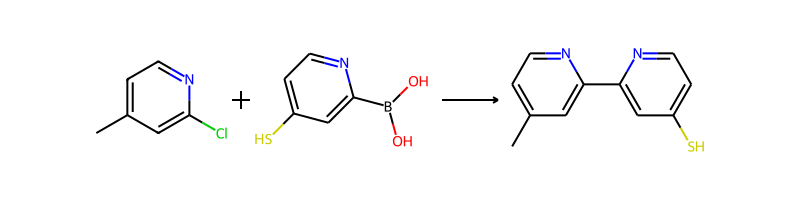

In [77]:
from rdkit.Chem import rdChemReactions
from rdkit.Chem.rdChemReactions import RemoveMappingNumbersFromReactions
rxn = AllChem.ReactionFromSmarts(results['rxn_smiles'][29013],useSmiles=True)
Chem.Draw.ReactionToImage(rxn)

In [78]:
AllChem.ReactionToSmiles(rxn)

'Cc1ccnc(Cl)c1.OB(O)c1cc(S)ccn1>>Cc1ccnc(-c2cc(S)ccn2)c1'

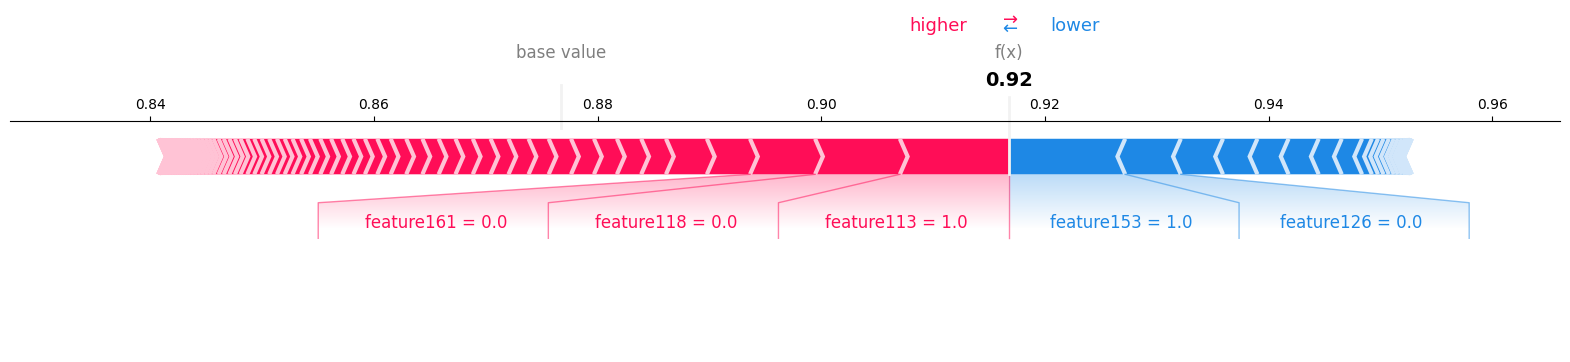

In [180]:
p(1900)

In [181]:
X_test[1900:1901]

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature324,feature325,feature326,feature327,feature328,feature329,feature330,feature331,feature332,feature333
17377,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,1,1,0


In [182]:
results[17377:17378]

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,Unnamed: 0,rxn_smiles,maccs,max_maccs_sim,maccs_1d
17377,17377,Oc1ccccc1Cl.OB(O)c1cccc(CCl)c1>>Oc1ccccc1-c1cc...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.923559,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


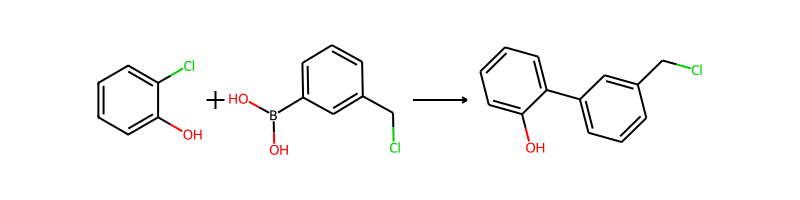

In [183]:
from rdkit.Chem import rdChemReactions
from rdkit.Chem.rdChemReactions import RemoveMappingNumbersFromReactions
rxn = AllChem.ReactionFromSmarts(results['rxn_smiles'][17377],useSmiles=True)
Chem.Draw.ReactionToImage(rxn)

In [184]:
AllChem.ReactionToSmiles(rxn)

'OB(O)c1cccc(CCl)c1.Oc1ccccc1Cl>>Oc1ccccc1-c1cccc(CCl)c1'